# Training a text classifier

## Dependencies

In [44]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
import torch
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

## Using a pretrained model

In [23]:
model_ckpt = "distilbert-base-uncased"

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Remember the tokenizer must be the same used for train the model

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

## Extracting the last hidden state for a single string

First we setup the tokenizer and extract encodings from a single string

In [26]:
text = "this is a text"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
# => tensor of [batch_size, n_tokens]

Input tensor shape: torch.Size([1, 6])


Next, we set the inputs on the same device used for the model

In [27]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad(): # disable automatic calculation of gradient descent
    outputs = model(**inputs)
print(f"Output tensor shape: {outputs.last_hidden_state.size()}")

Output tensor shape: torch.Size([1, 6, 768])


Depending on the model, outputs attributes can differ, this model in particular only returns the last hidden state

In [28]:
outputs.last_hidden_state.size()
# => tensor of [batch_size, n_tokens, hidden_dim]

torch.Size([1, 6, 768])

the last hidden state is:

In [29]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

## Extracting the last hidden states for the entire dataset

let's setup the dataset to use first

In [30]:
emotions = load_dataset("emotion")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True)
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Then we wrap all the previous steps in a single function and extract all hidden states

In [32]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Convert back to cpu to use numpy
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=4)

Map: 100%|██████████| 2000/2000 [00:04<00:00, 428.19 examples/s]


we can see the new 'hidden_state':

In [33]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Split the dataset into train and validation

In [34]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing the training set

We will use UMAP algorithm to project the 768 vectors in 2D

In [41]:
X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.369609,6.577972,0
1,-2.893385,5.887550,0
2,5.245619,3.204163,3
3,-2.347661,3.768390,2
4,-3.122734,3.958685,3


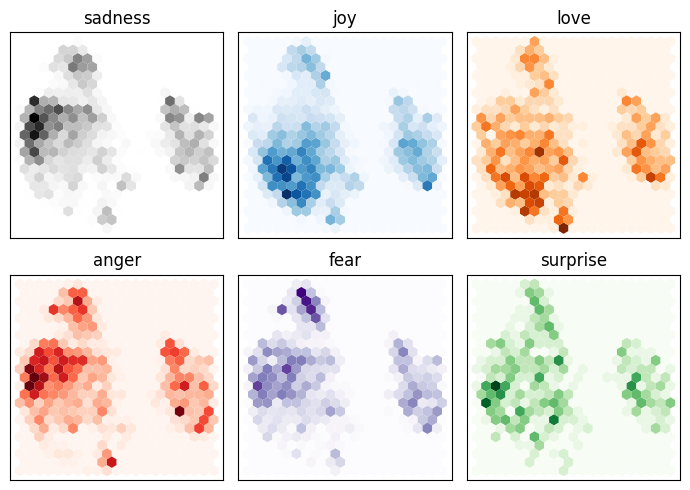

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

WIth this visualization, we can see that `sadness`, `anger` and `fear` occupy similar regions, this overlap does not mean that cannot be separated, remember this is a projection in 2D of a 768 dimensions, but this is not guaranteed.

We can see that `love` and `joy` are well separated from negative emotions